# 1. Imports

In [3]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

# 2. Data 

## 2.1 Loaders

### 2.1.1 MNIST Data

In [37]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

all_train_size = len(train_data)
little_train_size = int(0.8 * all_train_size)
val_size = all_train_size - little_train_size

little_train_dataset, val_dataset = random_split(train_data, [little_train_size, val_size])

little_train_dataloader = DataLoader(little_train_dataset,batch_size=batch_size,
    shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
train_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [38]:
subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(little_train_dataset, [subset_size, little_train_size  - subset_size])
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)

## 2.2 Data shape

In [6]:
for images, labels in little_train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# 3. Model

In [7]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x
    

    def weights_normal(self,mean,std):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=mean, std=std) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def weights_ones(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.ones_(m.weight) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

# 4. Training

In [8]:
def train(epochs:int,model,optimizer,criterion,data):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        batch_loss = []
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()
            
            batch_loss.append(loss.item())
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)}, loss: {loss.item():.4f}')
        avg_batch_loss = sum(batch_loss)/len(batch_loss)
        loss_history.append(avg_batch_loss)
            
    print('Finished training!')
    return loss_history

In [8]:
model_1 = Fcnn()
epochs = 8
optimizer = torch.optim.Adam(model_1.parameters())
criterion = nn.CrossEntropyLoss()

loss_history_1 = train(epochs, model_1, optimizer, criterion, little_train_dataloader)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/750, loss: 1.8494
epoch: 1, step: 200/750, loss: 1.7212
epoch: 1, step: 300/750, loss: 1.6741
epoch: 1, step: 400/750, loss: 1.5792
epoch: 1, step: 500/750, loss: 1.6236
epoch: 1, step: 600/750, loss: 1.6304
epoch: 1, step: 700/750, loss: 1.6745
epoch: 2, step: 100/750, loss: 1.5066
epoch: 2, step: 200/750, loss: 1.5189
epoch: 2, step: 300/750, loss: 1.5914
epoch: 2, step: 400/750, loss: 1.5572
epoch: 2, step: 500/750, loss: 1.5436
epoch: 2, step: 600/750, loss: 1.6568
epoch: 2, step: 700/750, loss: 1.5115
epoch: 3, step: 100/750, loss: 1.5444
epoch: 3, step: 200/750, loss: 1.5349
epoch: 3, step: 300/750, loss: 1.5416
epoch: 3, step: 400/750, loss: 1.4648
epoch: 3, step: 500/750, loss: 1.5020
epoch: 3, step: 600/750, loss: 1.5421
epoch: 3, step: 700/750, loss: 1.5285
epoch: 4, step: 100/750, loss: 1.5091
epoch: 4, step: 200/750, loss: 1.5186
epoch: 4, step: 300/750, loss: 1.4914
epoch: 4, step: 400/750, loss: 1.4973
epoch: 4, step: 500/750, loss: 1.4985
epoch: 4, st

# 5. Testing

In [9]:
def test(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            output = model(images)
            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(dataloader.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


In [10]:
accuracy_1 = test(model_1, test_dataloader)

Accuracy: 0.956


# 6. Weight initialization

## 6.1 Large weights

In [ ]:
model_2 = Fcnn()
optimizer = torch.optim.Adam(model_2.parameters())
model_2.weights_normal(mean=1000, std=20)

loss_history_2 = train(epochs, model_2, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3027
epoch: 1, step: 200/750, loss: 2.3028
epoch: 1, step: 300/750, loss: 2.3020
epoch: 1, step: 400/750, loss: 2.3017
epoch: 1, step: 500/750, loss: 2.3017


KeyboardInterrupt: 

In [ ]:
accuracy_2 = test(model_2, test_dataloader)

Accuracy: 0.113


## 6.2 All weights set to 1

In [36]:
model_3 = Fcnn()
optimizer = torch.optim.Adam(model_3.parameters())
model_3.weights_ones()

loss_history_3 = train(epochs, model_3, optimizer, criterion, little_train_dataloader)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/750, loss: 2.3026
epoch: 1, step: 200/750, loss: 2.3020
epoch: 1, step: 300/750, loss: 2.3025
epoch: 1, step: 400/750, loss: 2.3029
epoch: 1, step: 500/750, loss: 2.3020
epoch: 1, step: 600/750, loss: 2.3035
epoch: 1, step: 700/750, loss: 2.3005
epoch: 2, step: 100/750, loss: 2.3032
epoch: 2, step: 200/750, loss: 2.3045
epoch: 2, step: 300/750, loss: 2.3044
epoch: 2, step: 400/750, loss: 2.3020
epoch: 2, step: 500/750, loss: 2.3012
epoch: 2, step: 600/750, loss: 2.3035
epoch: 2, step: 700/750, loss: 2.3052
epoch: 3, step: 100/750, loss: 2.3040
epoch: 3, step: 200/750, loss: 2.2990
epoch: 3, step: 300/750, loss: 2.3039
epoch: 3, step: 400/750, loss: 2.3014
epoch: 3, step: 500/750, loss: 2.3034
epoch: 3, step: 600/750, loss: 2.2991
epoch: 3, step: 700/750, loss: 2.2973
epoch: 4, step: 100/750, loss: 2.3037
epoch: 4, step: 200/750, loss: 2.2982
epoch: 4, step: 300/750, loss: 2.3013
epoch: 4, step: 400/750, loss: 2.2997
epoch: 4, step: 500/750, loss: 2.2969
epoch: 4, st

KeyboardInterrupt: 

In [ ]:
accuracy_3 = test(model_3, test_dataloader)

Accuracy: 0.113


## 6.3 Results

C:\Users\Komputer\AppData\Local\Temp\ipykernel_11236\306140487.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


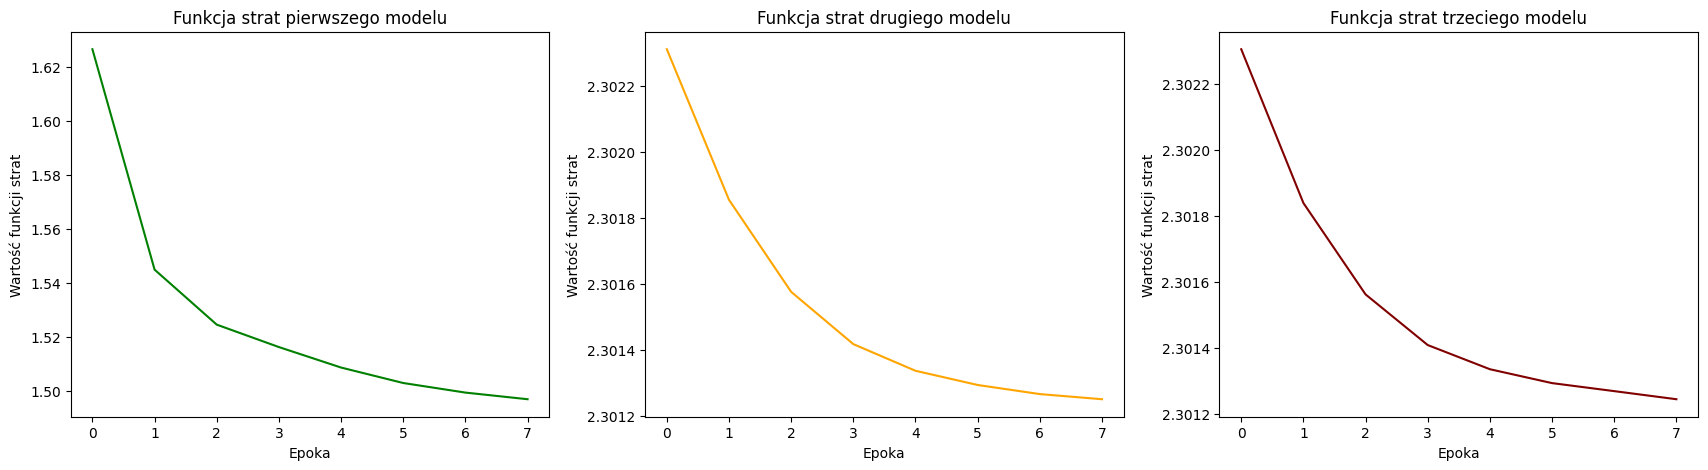

In [ ]:
plt.subplots(figsize=(21, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history_1, color='green')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat pierwszego modelu')

plt.subplot(1, 3, 2)
plt.plot(loss_history_2, color='orange')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat drugiego modelu')

plt.subplot(1, 3, 3)
plt.plot(loss_history_3, color='maroon')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat trzeciego modelu')

plt.show()

In [ ]:
plt.bar(['Model 1', 'Model 2', 'Model 3'], [accuracy_1, accuracy_2, accuracy_3], color=['green', 'orange', 'maroon'])
plt.title('Dokładność predykcji dokonywanych przez poszczególne modele')
plt.ylabel('Dokładność')

plt.show()

NameError: name 'accuracy_1' is not defined

Domyślne wagi zaimplementowane przez PyTorch (użyte w pierwszym modelu), czyli bardzo bliskie 0, działają najlepiej. Wyniki uzyskiwane przez model można wówczas uznać za satysfakcjonujące. Inicjalizacja innych wag sprawia, że wyniki predykcji modelu są bardzo dalekie od oczekiwań. Dotyczy to zarówno poprawności predykcji jak i funkcji strat.

# 7. Training on subsets of different sizes

In [15]:
subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []

for subset in subset_loaders:
    subset_model = Fcnn()
    optimizer = torch.optim.Adam(subset_model.parameters())
    loss_history = train(3,subset_model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(subset_model,test_dataloader)
    accuracy_train = test(subset_model,val_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training!
Accuracy: 0.625
Accuracy: 0.619
Finished training!
Accuracy: 0.650
Accuracy: 0.652
Finished training!
Accuracy: 0.788
Accuracy: 0.782
Finished training!
Accuracy: 0.868
Accuracy: 0.864
Finished training!
Accuracy: 0.796
Accuracy: 0.789


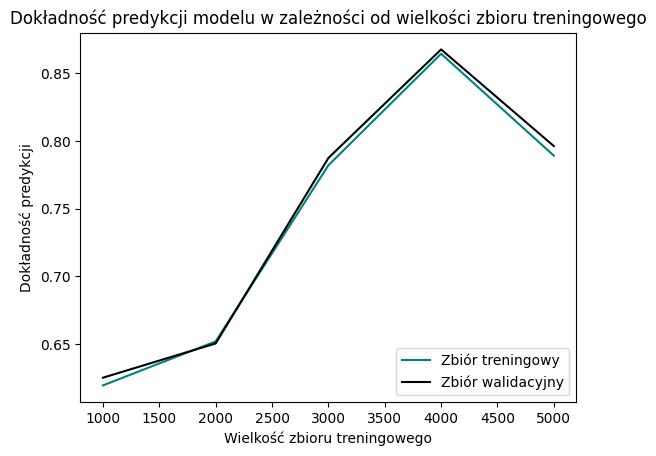

In [16]:
plt.plot(subset_sizes, subset_accuracy_train, label='Zbiór treningowy', color='teal')
plt.plot(subset_sizes, subset_accuracy_test, label='Zbiór walidacyjny', color='black')

plt.xlabel('Wielkość zbioru treningowego')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji modelu w zależności od wielkości zbioru treningowego')

plt.legend(loc='lower right')

Na powyższym wykresie możemy zauważyć trend wzrostowy w zależności pomiędzy zwiększaniem zbioru treningowego a dokładnością predykcji modelu.

# 8. Early stopping

In [39]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        print(self.min_validation_loss,validation_loss,validation_loss  > (self.min_validation_loss  + self.min_delta))
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
         
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train_es(epochs:int,model,optimizer,criterion,dataloader):
    early_stopper = EarlyStopper(patience=3)
    model.train()
    for epoch in range(epochs):
        batch_loss_history = []
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels)
            loss.backward()

            optimizer.step()
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(dataloader)} , loss: {loss.item():.4f}')
            batch_loss_history.append(loss.item())
        
        epoch_avg_loss = np.average(batch_loss_history)

        print(f'Epoch: {epoch+1}, avg_loss = {epoch_avg_loss}')
        if early_stopper.early_stop(epoch_avg_loss):
            print('Early stopping!')
            break
        
    print('Finished training!')



In [41]:
epochs = 35
model_4 = Fcnn()
learning_rate = 1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),lr=learning_rate)

train_es(epochs, model_4, optimizer, criterion, dataloader=train_dataloader)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/157 , loss: 2.0833
Epoch: 1, avg_loss = 2.0309160431479194
inf 2.0309160431479194 False
epoch: 2, step: 100/157 , loss: 1.7454
Epoch: 2, avg_loss = 1.7404190856180373
2.0309160431479194 1.7404190856180373 False
epoch: 3, step: 100/157 , loss: 1.6263
Epoch: 3, avg_loss = 1.654238176953261
1.7404190856180373 1.654238176953261 False
epoch: 4, step: 100/157 , loss: 1.5840
Epoch: 4, avg_loss = 1.631145331510313
1.654238176953261 1.631145331510313 False
epoch: 5, step: 100/157 , loss: 1.5104
Epoch: 5, avg_loss = 1.614453326364991
1.631145331510313 1.614453326364991 False
epoch: 6, step: 100/157 , loss: 1.7208
Epoch: 6, avg_loss = 1.6430586212000269
1.614453326364991 1.6430586212000269 True
epoch: 7, step: 100/157 , loss: 1.6490
Epoch: 7, avg_loss = 1.6003986946336783
1.614453326364991 1.6003986946336783 False
epoch: 8, step: 100/157 , loss: 1.5902
Epoch: 8, avg_loss = 1.5977822489039912
1.6003986946336783 1.5977822489039912 False
epoch: 9, step: 100/157 , loss: 1.5704
Epo

# 9. Dropout